# Project 8: Twitter US Airline Sentiment Analysis
### Data Description:
A sentiment analysis job about teh problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to firs classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

The project is from a dataset from Kaggle.
Link to the Kaggle project site: https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re, unicodedata
import contractions

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, f1_score, accuracy_score, precision_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data = pd.read_csv('Tweets.csv')

In [3]:
data.shape

(14640, 15)

In [4]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
data.isnull().sum(axis=0)

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

`We are only interested in the "text" and the "airline_sentiment" column for our purpose of sentiment analysis. And we can see that both of these columns have no null values`

In [6]:
# Remove all columns except 'ariline_sentiment' and 'text' column
data = data.loc[:,['airline_sentiment', 'text']]
data.shape

(14640, 2)

In [7]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (Non-turncated Text column.)
# print first five rows
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


### Text Pre-Processing

In [8]:
def strip_html(text):
    """Remove HTML tags"""
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

data['text'] = data['text'].apply(lambda x: strip_html(x))

In [9]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)
data['text'] = data['text'].apply(lambda x: replace_contractions(x))

data

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it
...,...,...
14635,positive,@AmericanAir thank you we got on a different flight to Chicago.
14636,negative,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. that is called shitty customer svc
14637,neutral,@AmericanAir Please bring American Airlines to #BlackBerry10
14638,negative,"@AmericanAir you have my money, you change my flight, and do not answer your phones! Any other suggestions so I can make my commitment??"


In [10]:
# Tokenization of data
data['text'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
data

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]"
...,...,...
14635,positive,"[@, AmericanAir, thank, you, we, got, on, a, different, flight, to, Chicago, .]"
14636,negative,"[@, AmericanAir, leaving, over, 20, minutes, Late, Flight, ., No, warnings, or, communication, until, we, were, 15, minutes, Late, Flight, ., that, is, called, shitty, customer, svc]"
14637,neutral,"[@, AmericanAir, Please, bring, American, Airlines, to, #, BlackBerry10]"
14638,negative,"[@, AmericanAir, you, have, my, money, ,, you, change, my, flight, ,, and, do, not, answer, your, phones, !, Any, other, suggestions, so, I, can, make, my, commitment, ?, ?]"


In [11]:
lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Remove numbers from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'\d+','', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_special_characters(words):
    """Remove special characters and punctuations from  list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^a-zA-Z\s]','', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
    
def lemmatize_list(words):
    """Lemmatize all words in list of tokenized words"""
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = remove_numbers(words)
    words = remove_special_characters(words)
    words = to_lowercase(words)
    words = lemmatize_list(words)
    return ' '.join(words)

data['text'] = data.apply(lambda row: normalize(row['text']), axis=1)


In [12]:
data.head()

,airline_sentiment,text
0,neutral,virginamerica what dhepburn say
1,positive,virginamerica plus you have add commercials to the experience tacky
2,neutral,virginamerica i do not today must mean i need to take another trip
3,negative,virginamerica it be really aggressive to blast obnoxious entertainment in your guests face they have little recourse
4,negative,virginamerica and it be a really big bad thing about it


### Vectorization
* Use CountVectorizer
* Use TfidfVectorizer

In [13]:
# Vectorization using CountVectorizer
vectorizer1 = CountVectorizer(max_features=1000)
data_features1 = vectorizer1.fit_transform(data['text'])
data_features1 = data_features1.toarray()
data_features1.shape

(14640, 1000)

In [14]:
# Vectorization using TfidfVectorizer
vectorizer2 = TfidfVectorizer(max_features=1000)
data_features2 = vectorizer2.fit_transform(data['text'])
data_features2 = data_features2.toarray()
data_features2.shape

(14640, 1000)

In [15]:
data_features2

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.17714312, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [16]:
from sklearn.preprocessing import LabelEncoder
data_copy = data.copy()
data_copy.head()

,airline_sentiment,text
0,neutral,virginamerica what dhepburn say
1,positive,virginamerica plus you have add commercials to the experience tacky
2,neutral,virginamerica i do not today must mean i need to take another trip
3,negative,virginamerica it be really aggressive to blast obnoxious entertainment in your guests face they have little recourse
4,negative,virginamerica and it be a really big bad thing about it


In [17]:
le = LabelEncoder()

In [18]:
data_copy['airline_sentiment'] = le.fit_transform(data_copy['airline_sentiment'])
data_copy.head()

,airline_sentiment,text
0,1,virginamerica what dhepburn say
1,2,virginamerica plus you have add commercials to the experience tacky
2,1,virginamerica i do not today must mean i need to take another trip
3,0,virginamerica it be really aggressive to blast obnoxious entertainment in your guests face they have little recourse
4,0,virginamerica and it be a really big bad thing about it


In [19]:
labels = data_copy['airline_sentiment']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data_features1, labels, test_size=0.3, random_state=10)

In [21]:
# Function to get confusion matrix in a proper format
def draw_cm(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot=True, fmt='g', xticklabels = ['negative', 'neutral', 'positive'], yticklabels = ['negative', 'neutral', 'positive'])
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.yticks(va="center")
    plt.show()

### Fit and evaluate model using CountVectorizer

In [22]:
forest = RandomForestClassifier(n_jobs=4)
forest = forest.fit(X_train, y_train)
score1 = np.mean(cross_val_score(forest, data_features1, labels, cv=10))

In [23]:
print(f"{score1 * 100:.2f}%")

73.75%


In [24]:
result1 = forest.predict(X_test)

Confusion Matrix


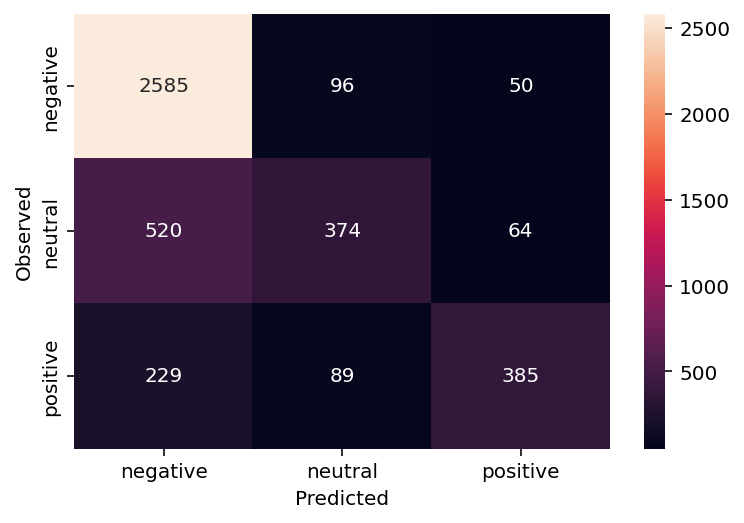

Accuracy: 76.14%


In [31]:
print('Confusion Matrix')
draw_cm(y_test, result1)
accuracy1 = accuracy_score(y_test, result1)
print(f"Accuracy: {accuracy1 * 100:.2f}%")

### Fit and evaluate model using TfidfVectorizer

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data_features2, labels, test_size=0.3, random_state=10)

In [27]:
forest2 = RandomForestClassifier(n_jobs=4)
forest2 = forest2.fit(X_train, y_train)
score2 = np.mean(cross_val_score(forest2, data_features2, labels, cv=10))

In [28]:
print(f"{score2 * 100:.2f}%")

73.29%


In [29]:
result2 = forest2.predict(X_test)

Confusion Matrix


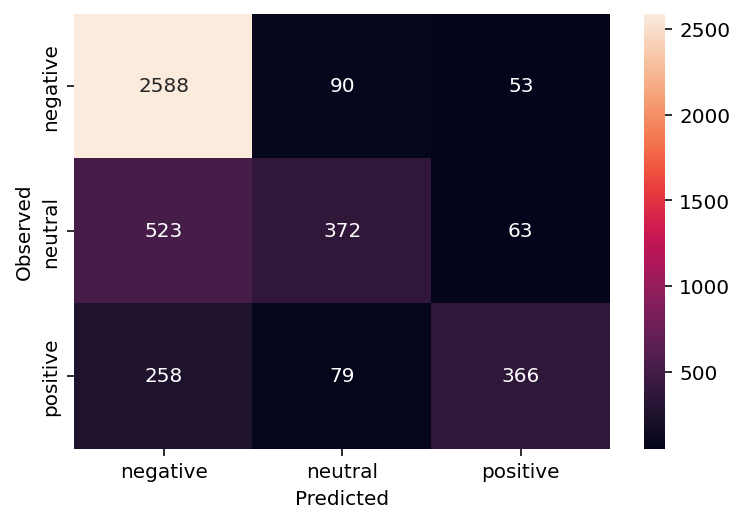

Accuracy: 75.73%


In [32]:
print('Confusion Matrix')
draw_cm(y_test, result2)
accuracy2 = accuracy_score(y_test, result2)
print(f"Accuracy: {accuracy2 * 100:.2f}%")

### Summary

#### Text Pre-Processing
We performed sentiment analysis by first performing text pre-processing. The text pre-processing is done to clean up the text in a way to make it usable for our model to be trained for sentiment analysis. Specifically, we striped any HTML, replaced contractions, then tokenized text/tweet. After tokenizing we followed up by converted and standardized the text int ASCII characters, in effect removing any potential accented characters. Finally, we removed any special characters, punctuations and numbers as well as convert the text to lowercase in order to then lemmatize the text.

#### Vectorization
We performed two different vectorizations: Count Vectorizer and Tf-idf Vectorer
While both methods represent the text as a bag of words, Count Vectorizer does make any words more important than others, they are all considered equally important. As for Tf-idf Vectorizer, it does take into account the frequency of words by reducing the impact of tokens that occur very frequently, hence offering litle to nothing in terms of information for those that occure frequently.

#### Model Performance
The model was trained using RandomForestClassifer for both Vectorization methods listed above. We also used cross validation to obtain our training accuracy.

Count Vectorizer model performance:  
The training accuracy was **73.75%** with an accuracy score of **76.14%** on test data

Tf-idf Vectorizer model performance:  
The training accuracy was **73.29%** with an accuracy score of **75.73%** on test data

Looking at the model performance we can conclude that although the model performed slightly better using Count Vectorizer, the accuracy is almost identical in both, therefore there isn't any real significant difference between the two types of vectorizations used. Furthermore, in both cases, the training and test accuracy was very close, which shows that model was not overfitted.